In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from decimal import Decimal
import datetime

In [3]:
import logging

# tato cast musi ist do gui, kde sa vytvori log subor, a inak to bude pouzivat iba default config
logging.basicConfig(level=logging.INFO,format='%(levelname)s (%(name)s): %(asctime)s >>> %(message)s', datefmt='%d-%b-%y %H:%M:%S', filename='Ilaps_log.txt')


In [4]:
logging.info('This will get logged to a file')

In [5]:
def get_timestamp(strTime):
    """format string time from iolite to timestamp"""
    return datetime.datetime.strptime(strTime, '%Y-%m-%d %H:%M:%S.%f')


def get_difference(start, now):
    """return time in seconds between 2 timestamps"""
    diff = now - start
    return diff.total_seconds()


def get_index(data, time):
    """return closest index of MS time given time in seconds"""
    for i in range(len(data.index)-1):
        if (data.index[i] <= time) and (data.index[i+1]>time):
                return i+1

def get_diff_lst(iolite):
    """return list of times in seconds from start to every start and end of laser ablation for spots"""
    lst = []
    for i in range(1,len(iolite['Timestamp'])-1):
        if (i-4)%5==0:
            lst.append(get_difference(get_timestamp(iolite.loc[i-2,'Timestamp']),get_timestamp(iolite.loc[i,'Timestamp'])))
            lst.append(get_difference(get_timestamp(iolite.loc[i,'Timestamp']),get_timestamp(iolite.loc[i+1,'Timestamp'])))
    lst.append(get_difference(get_timestamp(iolite.loc[i,'Timestamp']),get_timestamp(iolite.loc[i+1,'Timestamp'])))
    return lst

def get_diff_lst_line(iolite):
    """return list of times in seconds from start to every start and end of laser ablation for lines"""
    lst = []
    for i in range(1,len(iolite['Timestamp'])-1):
        if (i-6)%7==0:
            lst.append(get_difference(get_timestamp(iolite.loc[i-2,'Timestamp']),get_timestamp(iolite.loc[i,'Timestamp'])))
            lst.append(get_difference(get_timestamp(iolite.loc[i,'Timestamp']),get_timestamp(iolite.loc[i+1,'Timestamp'])))
    lst.append(get_difference(get_timestamp(iolite.loc[i-2,'Timestamp']),get_timestamp(iolite.loc[i,'Timestamp'])))
    return lst



In [6]:
class DataReader():  
    """
    Reads data into pandas Dataframe from a file.

    Parameters
    ----------
    filetype : str
        Type of the file to read. If not specified, csv is used. 
        Possible options are csv, xlsx and asc.
    instrument : str
        Type of the instrument used for measurement. If not specified, raw data is expected. 
        Possible options are Agilent, and Element.

    Returns
    -------
    data : dataframe
        `data` as a dataframe, which can be passed to MSData.

    """
    def __init__(self, filename, filetype=None, instrument=None):
        
        self.filename = filename
        self.filetype = filetype
        self.instrument = instrument
        self.data = self.read(filename, filetype, instrument)
        
    def __call__(self):
        return self.data
        
    def read(self, filename, filetype, instrument):
        if instrument == 'Element':
            skipfooter = 4
            header = 1
            drop = 9
        elif instrument == 'Agilent':
            skipfooter = 4
            header = 3
            drop = 3
        else:
            skipfooter = 0
            header = 0
            drop = 0

        if filetype == 'xlsx':
            imported = pd.ExcelFile(filename)
            data = imported.parse(0, index_col=0, skipfooter=skipfooter, header=header)
            data = sdata.drop(data.index[:drop], axis=0)

        elif filetype == 'csv':
            data = pd.read_csv(filename, sep=',', index_col=0, skipfooter=skipfooter,
                                    header=header, engine='python')

        elif filetype == 'asc':
            data = pd.read_csv(filename, sep='\t', index_col=0, skipfooter=skipfooter,
                                    header=header, engine='python')
            data = data.drop(data.index[:drop], axis=0)
            data.dropna(axis=1, how='all', inplace=True)
            data = data.apply(pd.to_numeric, errors='coerce')

        else:
            warnings.warn('File type not supported.')

        return data
    

In [7]:
def plot_data(data, isotopes=None, ax=None, *args, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    if isotopes is not None:
        ax.plot(data[isotopes], *args, **kwargs)
    else:
        ax.plot(data, *args, **kwargs)
    

In [8]:
class Session():
    pass

In [9]:
class MSData():
    def __init__(self, datareader):
        self.datareader = datareader
        logging.info(f'Reading data {self.datareader.filename}.')
        self.data = self.datareader()
        self.time = np.array(self.data.index)
        self.matrix = self.data.values
        self.isotope_names = np.array(self.data.columns)
        self.isotopes = {}
        
    def __call__(self, isotopes=None, *args, **kwargs):
        plot_data(self.data, isotopes=isotopes, *args, **kwargs)
        
    def __repr__(self):
        res = f'{self.__class__.__name__}\n Analysis time: {self.time.max()}s\n File path: {self.datareader.filename}\n Measured isotopes: {self.isotope_names}'
        return res
    
    def time_to_number(self, time):
        """
        takes time in seconds returns number of measured values
        depends on integration time of MS method
        """
        val = len(self.time[0:np.abs((self.time)-np.abs(time)).argmin()])
        #val = len(d.time[:np.abs((d.time)-np.abs(10)).argmin()])
        if time < 0: val = -val
        return val
    
    def create_isotopes(self):
        for key in self.isotope_names:
            self.isotopes[key] = Isotope(key, self)
    
    def create_selector(self):
        pass
    

In [10]:
class Isotope():   
    """
    Extract specific Isotope data from MSData object.

    Parameters
    ----------
    isotope_name : str
        Isotope to extract from MSData (i.e. Li7)
    ms_data : MSData
        MS data to extract from.
        
    Returns
    -------
    data : array
        `data` interpreted as an array.

    """
    def __init__(self, isotope_name, ms_data, *args, **kwargs):
        self.isotope_name = isotope_name
        self.isotope_number = int(''.join([c for c in self.isotope_name if c.isnumeric()]))
        self.data = ms_data.data[isotope_name].values
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.data[idx]
        return [self.data[i] for i in idx]
    def __call__(self):
        plt.plot(self.data)
    def __repr__(self):
        res = f'{self.__class__.__name__} {self.isotope_name} ({len(self)} values)\n{self.data[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res
    def __iter__(self): return iter(self.data)
    def __setitem__(self, i, o): self.data[i] = o
    def __delitem__(self, i): del(self.data[i])
    
    def element(self):
        return ''.join([c for c in self.isotope_name if c.isalpha()])
    
    def peakiefy(self, laser_on_off):
        pass
    
    
        

In [11]:
class Peak():
    def __init__(self, isotope, bounds, ms_data=None, *args, **kwargs):
        if isotope.data is None:
            raise ValueError('Missing data for isotope: {}'.format(isotope.isotope_name))
        self.data = isotope.data[bounds[0]:bounds[1]]
    def __len__(self):
        return len(self.data)
    def __call__(self):
        plt.plot(self.data)
    def __repr__(self):
        pass 

In [12]:
class Background():
    def __init__(self, isotope, laser_on, laser_off, ms_data=None, *args, **kwargs):
        assert isotope.data is not None
        self.bcg_beginning = isotope.data[laser_off[0][0]:laser_off[0][1]]
        self.bcg_end = isotope.data[laser_off[-1][0]:laser_off[-1][1]]
        self.bcg_all = [isotope.data[laser_off[i][0]:laser_off[i][1]] for i in range(len(laser_off))]
        self.bcg_means = [x.mean() for x in self.bcg_all]
    def __call__(self):
        plt.plot(self.bcg_means)
    def __repr__(self):
        return f'{self.__class__.__name__}: {self.bcg_means} '

In [13]:
class ElementalMap():
    def __init__(self, isotope, laser_on, laser_off, ms_data, *args, **kwargs):
        pass
    def __len__(self):
        pass
    def __call__(self):
        plt.plot(self.bcg_means)
    def __repr__(self):
        pass 

In [14]:
class Iolite():
    def __init__(self, path):
        self.data = self.read_iolite(path)
        self.peak_names = self.names_from_iolite(self.data)
        
    def read_iolite(self, path):
        iolite = pd.read_csv(path, sep=",", engine='python')
        return iolite
        
    def names_from_iolite(self, iolite):
        names = list(iolite[' Comment'].dropna())
        return names
    
    
    

In [15]:
class Selector():
    def __init__(self, ms_data, method = 'treshold', s=60, sdmul=10, iolite=None):
        self.possible_methods = ('treshold','iolite')
        self.ms_data = ms_data
        self.filter_line = self.ms_data.data.sum(1)
        self.method = method
        self.iolite = iolite
        self.start = s
        self.sdmul = sdmul
        
    def __call__(self):
        if method not in self.possible_methods:
            warnings.warn(f'{method} not implemented.\n Select from: {self.possible_methods}')
            return  
        elif self.method == 'treshold':
            return self.create_selector_treshold()
        elif self.method == 'iolite':
            return self.create_selector_iolite()
        
    
    def create_selector_iolite(self):
        """select starts and ends of ablation using iolite file """ 
        logging.info('Selecting peak bounds by iolite.')
        
        lst = [x for x in self.iolite.data.loc[:6, ' Comment'] if isinstance(x, str)]
        
        if len(lst) == 2:
            logging.info('Selecting spots.')
            difflst = get_diff_lst(self.iolite.data)
        elif len(lst) == 1:
            logging.info('Selecting lines.')
            difflst = get_diff_lst_line(self.iolite.data)
        else:
            logging.error('Iolite selection failed.')
            
        timeindex = []
        for i in range(0, len(difflst)+1):
            timeindex.append(sum(difflst[:i])+self.start)
        index =[get_index(self.ms_data.data, x) for x in timeindex]
        
        starts = [index[i] for i in range(len(index)) if i %2==0]
        ends = [index[i] for i in range(len(index)) if i %2!=0]
        
        return starts, ends
    
    def create_selector_treshold(self):
        """
        select starts and ends of ablation based on selected element or sum of all using treshold
        calculated from background
        """
        logging.info('Selecting peak bounds by setting treshold.')
        bcg_nr = self.ms_data.time_to_number(self.start)
        bcg = self.filter_line[0:bcg_nr].mean()
        std = self.filter_line[0:bcg_nr].std()
        ind = [True if value > bcg+self.sdmul*std else False for value in self.filter_line]
        ind2 = ind[1:]; ind2.append(False)
        index = [i for i in range(0,len(ind)) if ind[i]!=ind2[i]]
        
        starts = [index[i] for i in range(len(index)) if i %2==0]
        ends = [index[i] for i in range(len(index)) if i %2!=0]
        
        return starts, ends
        



In [16]:
class Quantifier():
    pass

In [17]:
reader = DataReader(filename='/Users/nikadilli/code/Ilaps/test_data/an1.csv', filetype='csv', instrument='Agilent')

In [18]:
d = MSData(reader)


In [19]:
io = Iolite('/Users/nikadilli/code/Ilaps/test_data/an1.Iolite.csv')
io.data

,Timestamp,Sequence Number,SubPoint Number,Vertix Number,Comment,X,Y,Intended X,Intended Y,Scan Velocity,Laser State,Laser Rep. Rate,Spot Type,Spot Size,Spot Angle,MFC1,MFC2,Cell Pressure,Fluence At Sample
0,2020-02-28 12:06:00.540,1.0,1.0,NaN,NIST610,55678,47276,NaN,NaN,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
1,2020-02-28 12:06:00.540,NaN,NaN,NaN,NaN,55678,47276,NaN,NaN,0.0,Off,0,Slit,65 x 65,0,0,0,0,NaN
2,2020-02-28 12:06:00.540,NaN,NaN,NaN,NaN,55678,47276,55678.0,47276.0,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
3,2020-02-28 12:06:00.780,NaN,NaN,NaN,NaN,55678,47276,NaN,NaN,NaN,On,20,Slit,65 x 65,0,0,0,0,NaN
4,2020-02-28 12:07:01.606,NaN,NaN,NaN,NaN,55678,47276,NaN,NaN,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
5,2020-02-28 12:08:03.624,2.0,1.0,NaN,NIST610,55769,47431,NaN,NaN,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
6,2020-02-28 12:08:03.624,NaN,NaN,NaN,NaN,55769,47431,NaN,NaN,0.0,Off,0,Slit,65 x 65,0,0,0,0,NaN
7,2020-02-28 12:08:03.624,NaN,NaN,NaN,NaN,55769,47431,55769.0,47431.0,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN
8,2020-02-28 12:08:03.720,NaN,NaN,NaN,NaN,55769,47431,NaN,NaN,NaN,On,20,Slit,65 x 65,0,0,0,0,NaN
9,2020-02-28 12:09:04.519,NaN,NaN,NaN,NaN,55769,47431,NaN,NaN,NaN,Off,0,Slit,65 x 65,0,0,0,0,NaN


In [20]:
select = Selector(d, 'iolite', 115)

In [21]:
starts, ends = select.create_selector_treshold()

In [22]:
d.create_isotopes()

In [23]:
d.isotopes

{'Li7': Isotope Li7 (1527 values)
 [0. 0. 0. 0. 0. 2. 0. 0. 0. 0....],
 'B11': Isotope B11 (1527 values)
 [3. 2. 1. 1. 2. 0. 1. 0. 0. 0....],
 'Na23': Isotope Na23 (1527 values)
 [49394.36 49240.45 49363.38 49512.14 49699.14 49127.86 49268.34 49083.45
  49014.25 49173.31...],
 'Mg24': Isotope Mg24 (1527 values)
 [2. 2. 2. 2. 0. 2. 2. 1. 1. 2....],
 'Al27': Isotope Al27 (1527 values)
 [32. 27. 32. 21. 17. 22. 16. 35. 15. 21....],
 'Si28': Isotope Si28 (1527 values)
 [27750.01 27312.1  26602.53 26699.22 26699.22 26082.53 25707.14 26055.06
  25449.81 25513.88...],
 'P31': Isotope P31 (1527 values)
 [214.02 230.02 203.01 182.01 216.02 191.01 183.01 211.01 180.01 188.01...],
 'K39': Isotope K39 (1527 values)
 [2916.85 2959.94 2944.91 3002.02 3015.05 2844.71 2884.79 2954.93 2903.83
  2856.73...],
 'Ca43': Isotope Ca43 (1527 values)
 [4. 3. 4. 4. 3. 5. 2. 5. 6. 8....],
 'Ca44': Isotope Ca44 (1527 values)
 [333.04 295.03 319.03 280.03 278.03 266.02 280.03 286.03 317.03 293.03...],
 'Sc45': Iso

In [24]:
d.data['Na23'].values

array([49394.36, 49240.45, 49363.38, ..., 73462.81, 72579.52, 72272.27])

<IPython.core.display.Javascript object>


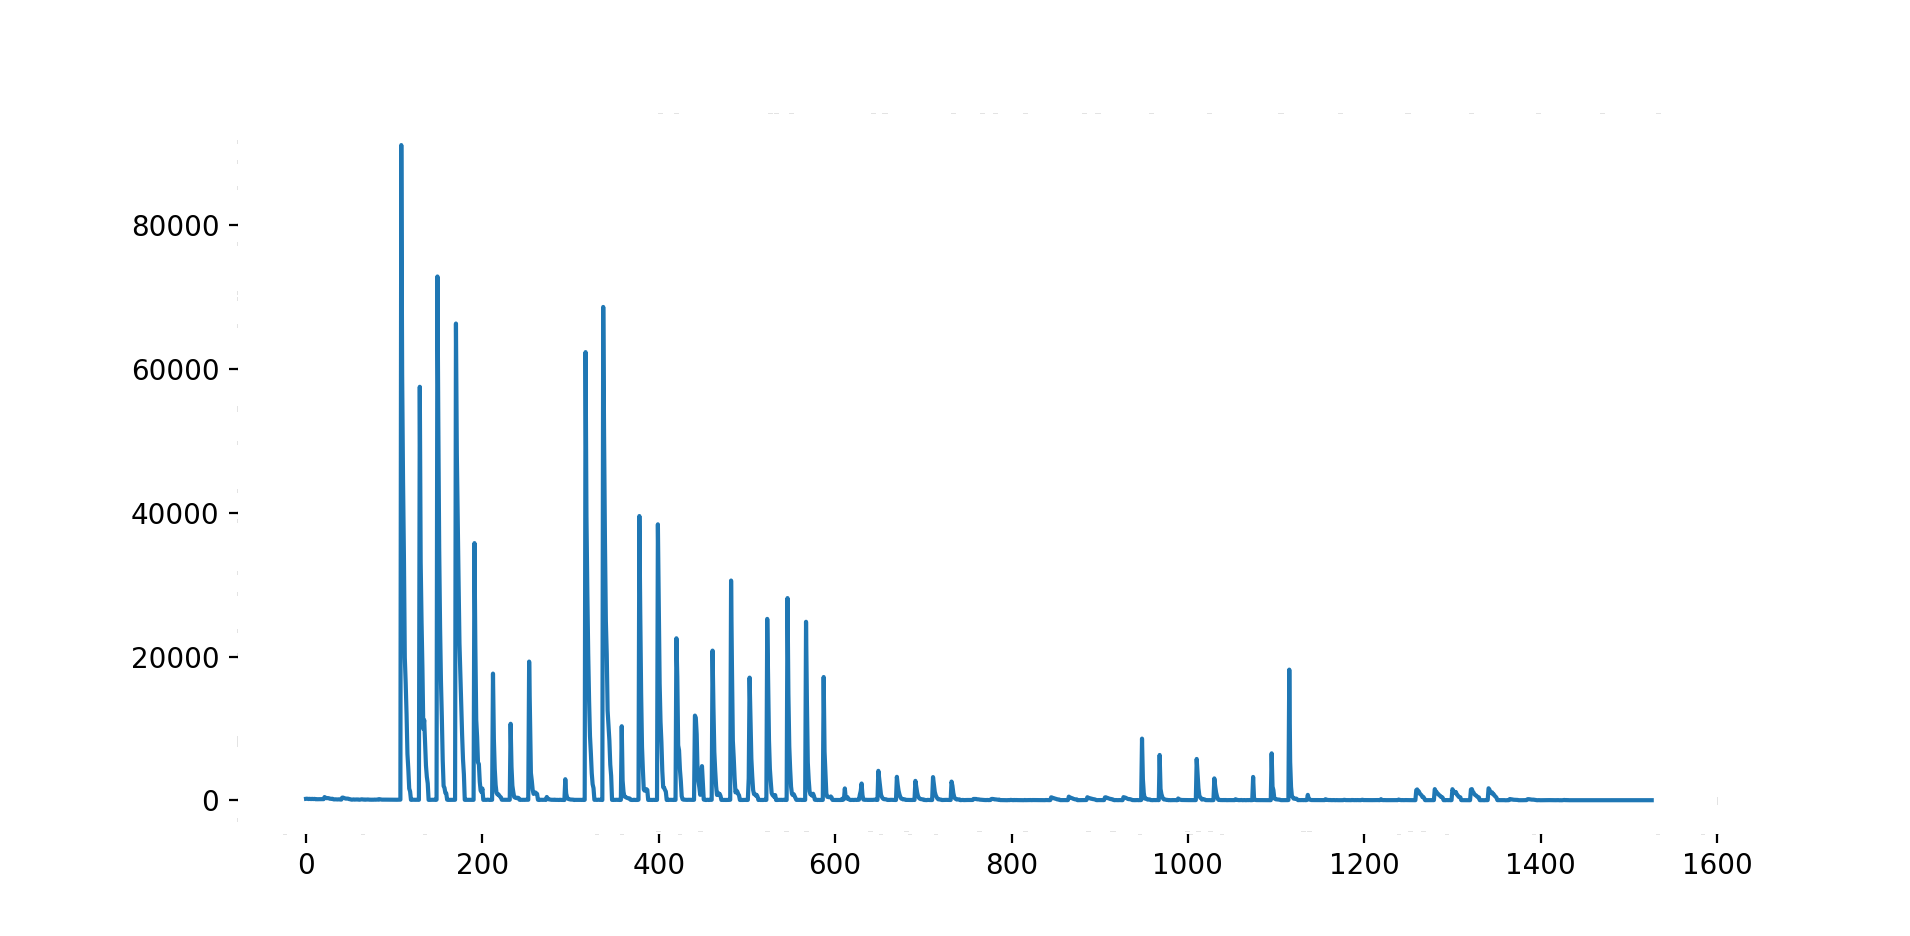

In [25]:
d.isotopes['P31']()